In [1]:
using JuMP
using Ipopt
using GLPKMathProgInterface
#using Cbc
using DataArrays, DataFrames, CSV
using Gadfly
using Pajarito
#using CPLEX

In [2]:
###  Data definition
#Generators data

GenData = DataFrame(
    Bus = [18,21,1,2,15,16,23,23,7,13,15,22],
    Pmax = [400,400,152,152,155,155,310,350,350,591,60,300],
    Pmin = [100,100,30.40,30.40,54.25,54.25,108.50,140,75,206.85,12,0],
    c = [5.47,5.47,13.32,13.32,16,10.52,10.52,10.89,20.7,20.93,26.11,0],
    a = [0.5,0.6,0.7,0.4,0.5,0.7,0.5,0.3,0.4,0.5,0.7,0.8],
    RU = [47,47,14,14,21,21,21,28,49,21,7,35],
    RD = [47,47,14,14,21,21,21,28,49,21,7,35])

#Number of generators
NGen = size(GenData,1) 
# Generator limits
Pmin = zeros(NGen); 
Pmax = zeros(NGen); 
Qmin = zeros(NGen); 
Qmax = zeros(NGen);
# Generation costs
c = zeros(NGen);
a = zeros(NGen);
Bus = zeros(NGen);
#RumpUp
RU = zeros(NGen);
#RumpDown
RD = zeros(NGen);



for i=1:NGen
    Bus[i] = GenData[i,:Bus]
    Pmin[i] = GenData[i,:Pmin]
    Pmax[i] = GenData[i,:Pmax]
    c[i] = GenData[i,:c]
    a[i] = GenData[i,:c]
    RU[i] = GenData[i,:RU]
    RD[i] = GenData[i,:RD]
    
end    
    
GenData

,Bus,Pmax,Pmin,c,a,RU,RD
1,18,400,100.0,5.47,0.5,47,47
2,21,400,100.0,5.47,0.6,47,47
3,1,152,30.4,13.32,0.7,14,14
4,2,152,30.4,13.32,0.4,14,14
5,15,155,54.25,16.0,0.5,21,21
6,16,155,54.25,10.52,0.7,21,21
7,23,310,108.5,10.52,0.5,21,21
8,23,350,140.0,10.89,0.3,28,28
9,7,350,75.0,20.7,0.4,49,49
10,13,591,206.85,20.93,0.5,21,21


In [3]:
# Lines data
BranchData = DataFrame(
    FromBus = [1,1,1,2,2,3,3,4,5,6,7,8,8,9,9,10,10,11,11,12,12,13,14,15,15,15,16,16,17,17,18,19,20,21],
    ToBus = [2,3,5,4,6,9,24,9,10,10,8,9,10,11,12,11,12,13,14,13,23,23,16,16,21,24,17,19,18,22,21,20,23,22],
    r = [0.0026,0.0546,0.0218,0.0328,0.0497,0.0308,0.0023,0.0268,0.0228,0.0139,0.0159,0.0427,0.0427,0.0023,0.0023,0.0023,0.0023,0.0061,0.0054,0.0061,0.0124,0.0111,0.0050,0.0022,0.0032,0.0067,0.0033,0.0030,0.0018,0.0135,0.0017,0.0026,0.0014,0.0087],
    x = [0.0139,0.2112,0.0845,0.1267,0.1920,0.1190,0.0839,0.1037,0.0883,0.0605,0.0614,0.1651,0.1651,0.0839,0.0839,0.0839,0.0839,0.0476,0.0418,0.0476,0.0966,0.0865,0.0389,0.0173,0.0245,0.0519,0.0259,0.0231,0.0144,0.1053,0.0130,0.0198,0.0108,0.0678],
    b = [0.4611,0.0572,0.0229,0.0343,0.0520,0.0322,0.0000,0.0281,0.0239,2.4590,0.0166,0.0447,0.0447,0.0000,0.0000,0.0000,0.0000,0.0999,0.0879,0.0999,0.2030,0.1818,0.0818,0.0364,0.2060,0.1091,0.0545,0.0485,0.0303,0.2212,0.1090,0.1666,0.0910,0.1424],
    Smax = [175,175,175,175,175,175,400,175,175,175,175,175,175,400,400,400,400,500,500,500,500,500,500,500,1000,500,500,500,500,500,1000,1000,1000,500],)


NBuses = max(maximum(BranchData[:,:FromBus]), maximum(BranchData[:,:ToBus]));
NLines = size(BranchData,1);
BranchData[:Z]=BranchData[:r]+im*BranchData[:x];
BranchData[:Y]=1./BranchData[:Z];
Ybus = zeros(Complex,NBuses,NBuses);
Nodes = zeros(Int8,NLines,2); #node's matrix
SLmax = zeros(NLines); #line limits
x = zeros(NLines);
r = zeros(NLines);


for i=1:NLines
    
    Ybus[BranchData[i,:FromBus],BranchData[i,:ToBus]]=-BranchData[i,:Y]
    Ybus[BranchData[i,:ToBus],BranchData[i,:FromBus]]=-BranchData[i,:Y]
    Nodes[i,1] = BranchData[i,:FromBus]
    Nodes[i,2] = BranchData[i,:ToBus]
    SLmax[i] = BranchData[i,:Smax]
    x[i] = BranchData[i,:x]
    r[i] = BranchData[i,:x]
end

for i=1:NBuses
    for j=1:NLines
        if (i==BranchData[j,:FromBus])||(i==BranchData[j,:ToBus])
            Ybus[i,i]+=BranchData[j,:Y]
        end
    end
end

Gbus = real(Ybus);
Bbus = imag(Ybus);

BranchData


,FromBus,ToBus,r,x,b,Smax,Z,Y
1,1,2,0.0026,0.0139,0.4611,175,0.0026+0.0139im,13.002-69.5104im
2,1,3,0.0546,0.2112,0.0572,175,0.0546+0.2112im,1.14738-4.43822im
3,1,5,0.0218,0.0845,0.0229,175,0.0218+0.0845im,2.86259-11.0958im
4,2,4,0.0328,0.1267,0.0343,175,0.0328+0.1267im,1.91491-7.39693im
5,2,6,0.0497,0.192,0.052,175,0.0497+0.192im,1.26354-4.88126im
6,3,9,0.0308,0.119,0.0322,175,0.0308+0.119im,2.03843-7.87577im
7,3,24,0.0023,0.0839,0.0,400,0.0023+0.0839im,0.326496-11.91im
8,4,9,0.0268,0.1037,0.0281,175,0.0268+0.1037im,2.33614-9.03946im
9,5,10,0.0228,0.0883,0.0239,175,0.0228+0.0883im,2.74146-10.6172im
10,6,10,0.0139,0.0605,2.459,175,0.0139+0.0605im,3.60715-15.7002im


In [4]:
NodesData = DataFrame(
    Pd = [108,97,180,74,71,136,125,171,175,195,0,0,265,194,317,100,0,333,181,128,0,0,0,0],
    Qd = [22,20,37,15,14,28,25,35,36,40,0,0,54,39,64,20,0,68,37,26,0,0,0,0],
    Wind = [0,0,0,0,0,0,0,200,0,0,0,0,0,0,0,0,0,0,150,0,100,0,0,0],
    SOC = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,0,100,0,0,0],
)
ScaleData = DataFrame(
    w = [0.0786666666666667,0.0866666666666667,0.117333333333333,0.258666666666667,0.361333333333333,0.566666666666667,0.650666666666667,0.566666666666667,0.484,0.548,0.757333333333333,0.710666666666667,0.870666666666667,0.932,0.966666666666667,1,0.869333333333333,0.665333333333333,0.656 ,0.561333333333333,0.565333333333333,0.556,0.724,0.84],
    d = [0.684511335492475,0.644122690036197,0.61306915602972,0.599733282530006,0.588874071251667,0.5980186702229,0.626786054486569,0.651743189178891,0.706039245570585,0.787007048961707,0.839016955610593,0.852733854067441,0.870642027052772,0.834254143646409,0.816536483139646,0.819394170318156,0.874071251666984,1,0.983615926843208,0.936368832158506,0.887597637645266,0.809297008954087,0.74585635359116,0.733473042484283],
)
    
T = size(ScaleData,1); #Time scale

Pload = zeros(NBuses); # Demand
Ql = zeros(NBuses); 
Wind = zeros(NBuses); #Wind turbaine capacity
SOC_d = zeros(NBuses); #SOC capacity

w = zeros(T); #Wind profile coefficients
d = zeros(T);  #Demand profile coefficients


for i=1:NBuses
    
    Pload[i] = NodesData[i,:Pd]
    Ql[i] = NodesData[i,:Qd]
    Wind[i] = NodesData[i,:Wind]
    SOC_d[i] = NodesData[i,:SOC]
   
end

for i=1:T
    w[i] = ScaleData[i,:w]
    d[i] = ScaleData[i,:d]
end

# Voltage limits
Vmin = 0.9;
Vmax = 1.15;

#Angle limits

θmax = pi/2;
θmin = -pi/2;

SlackBus = 13;

Sbase = 100;

SOC_max = 20;
SOC_min = 0.2*SOC_max;
SOC_0 = 0.2*SOC_max; #initial charge
Pd_min = 0*SOC_max; #discharge limits
Pd_max = 0.2*SOC_max;
Pc_min = 0*SOC_max; #charge limits
Pc_max = 0.2*SOC_max;
#charge/discharge efficiency 
ηс = 0.95;
ηd = 0.9;
#Wind power limits
Pw_min = 0*Wind;
Pw_max = Wind;
Pwc_min = 0*Wind;
Pwc_max = Wind;
#Load shedding limits
Ls_min = 0*Pload;
Ls_max = Pload;

VOLL = 10000;
VOLW = 50;

N_max = 15; #total number of ESS in the system
NESS_max = 5; #limit of ESS in the bus

NodesData



,Pd,Qd,Wind,SOC
1,108,22,0,0
2,97,20,0,0
3,180,37,0,0
4,74,15,0,0
5,71,14,0,0
6,136,28,0,0
7,125,25,0,0
8,171,35,200,0
9,175,36,0,0
10,195,40,0,0


In [5]:
# Set size
NI = NBuses;
NL = NLines;
NG = NGen;


In [6]:
#m = Model(solver = GLPKSolverMIP())
#m = Model(solver = IpoptSolver());
#m = Model(solver =  CbcSolver());
#m = Model(solver = PajaritoSolver(mip_solver = GLPKSolverMIP())
#m = Model(solver = PajaritoSolver()
m=Model(solver = PajaritoSolver(mip_solver = GLPKSolverMIP(), cont_solver = IpoptSolver()))    

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Pajarito

In [7]:
@variable(m, p[g=1:NG,t=1:T]);

@variable(m, pl[l=1:NL,t=1:T]);

@variable(m, θ[i=1:NI,t=1:T]);
@variable(m, Ls[i=1:NI,t=1:T]);
@variable(m, SOC[i=1:NI,t=1:T]);
@variable(m, pd[i=1:NI,t=1:T]);
@variable(m, pc[i=1:NI,t=1:T]);
@variable(m, pw[i=1:NI,t=1:T]);
@variable(m, pwc[i=1:NI,t=1:T]);
@variable(m, NESS[i=1:NI], Int);
#@variable(m, NESS[i=1:NI]);

In [8]:
#Nodal balance equation
@constraint(m, BalanceEq[i=1:NI, t=1:T], sum(p[g,t] for g=1:NG if Bus[g]==i) + Ls[i,t] + pw[i,t] - Pload[i]*d[t]/Sbase - pc[i,t] + pd[i,t] == 
                sum(pl[l,t] for l=1:NL if Nodes[l,1]==i) - sum(pl[l,t] for l=1:NL if Nodes[l,2]==i));

In [9]:
#Branch power flow defenition
@constraint(m, PowerFlow[l=1:NL,t=1:T], pl[l,t] == (θ[Nodes[l,1],t]-θ[Nodes[l,2],t])/x[l]);
@constraint(m, FlowLimits[l=1:NL,t=1:T], -SLmax[l]/Sbase <= pl[l,t] <= SLmax[l]/Sbase);


In [10]:
#Technical generation limits
@constraint(m, GenLimitsP[g=1:NG,t=1:T], Pmin[g]/Sbase <= p[g,t] <= Pmax[g]/Sbase);
@constraint(m, RumpUp[g=1:NG,t=2:T], p[g,t] - p[g,t-1]  <= RU[g]/Sbase);
@constraint(m, RumpDown[g=1:NG,t=2:T], p[g,t-1] - p[g,t]  <= RD[g]/Sbase);

In [11]:
#Angle limits
@constraint(m, limitAngle1[i=SlackBus,t=1:T], θ[i,t] == 0);
@constraint(m, limitAngle2[i=1:NI,t=1:T], θmin <= θ[i,t] <= θmax);

In [12]:
#Charge balance
@constraint(m,ChargeBal1[i=1:NI,t=1], SOC[i,t] == NESS[i]*SOC_0/Sbase  + pc[i,t]*ηс - pd[i,t]/ηd);
@constraint(m,ChargeBal2[i=1:NI,t=2:T], SOC[i,t] == SOC[i,t-1] + pc[i,t]*ηс - pd[i,t]/ηd);
@constraint(m,ChargeBal3[i=1:NI,t=T], SOC[i,t] == NESS[i]*SOC_0/Sbase);
@constraint(m,ChargeBal4[i=1:NI,t=1:T], SOC[i,t] <= NESS[i]*SOC_max/Sbase);
@constraint(m,ChargeBal5[i=1:NI,t=1:T], pd[i,t] <= NESS[i]*Pd_max/Sbase);
@constraint(m,ChargeBal6[i=1:NI,t=1:T], pc[i,t] <= NESS[i]*Pc_max/Sbase);
@constraint(m,ChargeBal7[i=1:NI,t=1:T], SOC[i,t] >= NESS[i]*SOC_min/Sbase);
@constraint(m,ChargeBal8[i=1:NI,t=1:T], pd[i,t] >= NESS[i]*Pd_min/Sbase);
@constraint(m,ChargeBal9[i=1:NI,t=1:T], pc[i,t] >= NESS[i]*Pc_min/Sbase);
@constraint(m,ChargeBal10, sum(NESS[i] for i=1:NI) <= N_max);
@constraint(m,ChargeBal11[i=1:NI], NESS[i]  <= NESS_max);
    

In [13]:
#Wind constraine
@constraint(m,Wind1[i=1:NI,t=1:T], pw[i,t] + pwc[i,t] == w[t]*Wind[i]/Sbase);
@constraint(m,Wind2[i=1:NI,t=1:T], Pw_min[i]/Sbase <= pw[i,t] <= w[t]*Pw_max[i]/Sbase);
@constraint(m,Wind3[i=1:NI,t=1:T], Pwc_min[i]/Sbase <= pwc[i,t] <= w[t]*Pwc_max[i]/Sbase);

In [14]:
#Load shedding
@constraint(m,Load[i=1:NI,t=1:T], Ls_min[i]/Sbase <= Ls[i,t] <= d[t]*Ls_max[i]/Sbase);

In [15]:
#Objective function
@objective(m, Min, sum((pl[l,t]*Sbase)^2*r[l] for l=1:NL,t=1:T) + sum(c[g]*p[g,t]*Sbase for g=1:NG,t=1:T) + sum(VOLL*Ls[i,t]*Sbase for i=1:NI,t=1:T) + 
    sum(VOLW*pwc[i,t]*Sbase for i=1:NI,t=1:T));
#a[g]*p[g,t]^2 + 

In [16]:
#print(m)

In [17]:
solve(m)

Objective function is nonlinear

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    11376
Number of nonzeros in inequality constraint Jacobian.:     9144
Number of nonzeros in Lagrangian Hessian.............:      816

Total number of variables............................:     5160
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bound

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    11328
Number of nonzeros in inequality constraint Jacobian.:     6792
Number of nonzeros in Lagrangian Hessian.............:      816

Total number of variables............................:     5136
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3768
Total number of inequality constraints...............:     6265
        inequality constraints with only lower bounds:     1728
   inequality constraints with lower and upper bounds:     2232
        inequality constraints with only upper bounds:     2305

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    11328
Number of nonzeros in inequality constraint Jacobian.:     6792
Number of nonzeros in Lagrangian Hessian.............:      816

Total number of variables............................:     5136
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3768
Total number of inequality constraints...............:     6265
        inequality constraints with only lower bounds:     1728
   inequality constraints with lower and upper bounds:     2232
        inequality constraints with only upper bounds:     2305

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

:Optimal

In [18]:
getobjectivevalue(m)


863988.8010246694

In [19]:
getvalue(NESS)

24-element Array{Float64,1}:
 5.0
 5.0
 0.0
 1.0
 1.0
 3.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [20]:
Pg=getvalue(p);
GenPower = DataFrame();
GenPower[:g1] = Pg[1,:];
GenPower[:g2] = Pg[2,:];
GenPower[:g3] = Pg[3,:];
GenPower[:g4] = Pg[4,:];
GenPower[:g5] = Pg[5,:];
GenPower[:g6] = Pg[6,:];
GenPower[:g7] = Pg[7,:];
GenPower[:g8] = Pg[8,:];
GenPower[:g9] = Pg[9,:];
GenPower[:g10] = Pg[10,:];
GenPower[:g11] = Pg[11,:];
GenPower[:g12] = Pg[12,:];


GenPower

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12
1,3.25108,1.66692,1.52,1.52,0.647442,1.55,1.72273,1.4,2.15196,2.80844,0.12,0.796003
2,3.00674,1.49952,1.52,1.52,0.5425,1.55,1.51273,1.4,1.95,2.59844,0.12,0.780981
3,2.8478,1.3612,1.52,1.52,0.5425,1.55,1.33254,1.4,1.81573,2.38844,0.12,0.773387
4,2.74319,1.13555,1.52,1.52,0.5425,1.55,1.17442,1.4,1.60448,2.24097,0.12,0.765155
5,2.61868,1.0,1.52,1.52,0.5425,1.55,1.085,1.4,1.44419,2.12746,0.12,0.751418
6,2.2209,1.0,1.52,1.52,0.5425,1.55,1.085,1.4,1.15483,2.30136,0.12,0.678947
7,2.35698,1.0,1.52,1.52,0.5425,1.55,1.085,1.4,1.14937,2.51136,0.12,0.684603
8,2.7395,1.0,1.52,1.52,0.5425,1.55,1.085,1.4,1.34255,2.72136,0.12,0.734922
9,3.20868,1.11127,1.52,1.52,0.7525,1.55,1.295,1.4755,1.68111,2.93136,0.12,0.778694
10,3.67867,1.38595,1.52,1.52,0.9625,1.55,1.505,1.7555,2.01519,3.14136,0.12,0.809522


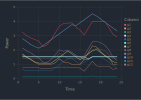

In [21]:
plot1=plot(GenPower, x = Row.index, y=Col.value(:g1,:g2,:g3,:g4,:g5,:g6,:g7,:g8,:g9,:g10,:g11,:g12),
    color=Col.index(:g1,:g2,:g3,:g4,:g5,:g6,:g7,:g8,:g9,:g10,:g11,:g12),  
    Geom.line,

    
   
  

Guide.XLabel("Time"),
Guide.YLabel("Power"),
#Guide.Title("Title")
)

In [22]:
PowerBalance = DataFrame();
PowerBalance[:Load] = sum(Pload)*d[:];
PowerBalance[:Gen] = sum(getvalue(p[g,:]) for g=1:NG)*Sbase;
PowerBalance[:SOC] = sum(getvalue(SOC[i,:]) for i=1:NI)*Sbase;
PowerBalance[:Wind] = sum(getvalue(pw[i,:]) for i=1:NI)*Sbase;
PowerBalance

,Load,Gen,SOC,Wind
1,1950.86,1915.46,60.0,35.4
2,1835.75,1800.09,63.1739,39.0
3,1747.25,1717.16,84.7513,52.8
4,1709.24,1631.63,121.6,116.4
5,1678.29,1567.92,171.222,162.6
6,1704.35,1509.35,228.222,255.0
7,1786.34,1543.98,276.141,292.8
8,1857.47,1627.58,300.0,255.0
9,2012.21,1794.41,300.0,217.8
10,2242.97,1996.37,300.0,246.6


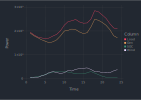

In [23]:
plot2=plot(PowerBalance, x = Row.index, y=Col.value(:Load,:Gen,:SOC,:Wind),
    color=Col.index(:Load,:Gen,:SOC,:Wind),  
    Geom.line,

    
   
  

Guide.XLabel("Time"),
Guide.YLabel("Power"),
#Guide.Title("Title")
)

In [78]:
getvalue(p)

12×24 Array{Float64,2}:
 4.0       4.0       3.53     3.06     …  4.0      3.82194  3.35194  2.88194
 4.0       3.79292   3.76133  3.29133     4.0      3.53     3.06     2.59   
 0.444     0.304     0.304    0.304       0.584    0.444    0.304    0.304  
 0.444     0.304     0.304    0.304       0.584    0.444    0.304    0.304  
 0.5425    0.5425    0.5425   0.5425      0.9625   0.7525   0.5425   0.5425 
 0.810573  0.600573  0.5425   0.5425   …  1.1725   0.9625   0.7525   0.5425 
 1.295     1.085     1.085    1.085       2.68     2.47     2.26     2.05   
 1.68      1.4       1.4      1.4         2.45791  2.17791  1.89791  1.61791
 0.75      0.75      0.75     0.75        0.75     0.75     0.75     0.75   
 2.0685    2.0685    2.0685   2.0685      2.0685   2.0685   2.0685   2.0685 
 0.12      0.12      0.12     0.12     …  0.12     0.12     0.12     0.12   
 3.0       3.0       3.0      3.0         3.0      3.0      3.0      3.0    

In [15]:
OutBranch = DataFrame()
OutBranch[:Line] = (1:NL)
OutBranch[:FromBus] = Nodes[:,1]
OutBranch[:ToBus] = Nodes[:,2]
OutBranch[:Pflow_p] = round(getvalue(pl[1:NL,1]),2)
OutBranch[:Qflow_p] = round(getvalue(ql[1:NL,1]),2)
OutBranch[:Pflow_n] = round(getvalue(pl[NL+1:2*NL,1]),2)
OutBranch[:Qflow_n] = round(getvalue(ql[NL+1:2*NL,1]),2)

OutBranch[:Sflow_p] = zeros(6)
OutBranch[:Sflow_n] = zeros(6)
for i=1:NL
OutBranch[i,:Sflow_p] = round(sqrt((getvalue(pl[i,1]))^2+(getvalue(ql[i,1]))^2),2)
OutBranch[i,:Sflow_n] = round(sqrt((getvalue(pl[i+NL,1]))^2+(getvalue(ql[i+NL,1]))^2),2)
end
OutBranch[:Slimits] = SLmax
OutBranch

,Line,FromBus,ToBus,Pflow_p,Qflow_p,Pflow_n,Qflow_n,Sflow_p,Sflow_n,Slimits
1,1,1,2,-0.65,0.06,0.65,-0.03,0.65,0.65,1.0
2,2,1,3,0.18,0.24,-0.18,-0.23,0.3,0.3,1.5
3,3,1,4,0.46,0.49,-0.46,-0.46,0.67,0.65,2.0
4,4,2,3,0.82,0.22,-0.82,-0.17,0.85,0.83,1.5
5,5,2,5,0.95,0.43,-0.94,-0.35,1.04,1.0,2.0
6,6,4,5,-0.14,-0.04,0.14,0.05,0.15,0.15,1.0


In [23]:
#CSV.write("Branch_OPF_R.csv", OutBranch)
#CSV.write("Node_OPF_R.csv", OutNode)

CSV.Sink(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        null: ""
        dateformat: dateformat"yyyy-mm-dd", IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "Node_OPF_R.csv", 116, true, String["Bus", "Pg", "Qg", "Pd", "Qd", "V", "θ", "Pgmax", "Pgmin", "Qgmax", "Qgmin", "Vmax", "Vmin", "θmax", "θmin", "Cost", "TotalCost"], false)